<a href="https://colab.research.google.com/github/alexander-n-thomas/spark-nlp-book-prod/blob/master/3_12_Sentiment_Analysis_and_Emotion_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os

# Install java
! apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]
! java -version

# Install pyspark
! pip install --ignore-installed pyspark==2.4.4

# Install Spark NLP
! pip install --ignore-installed spark-nlp==2.5.1

openjdk version "1.8.0_342"
OpenJDK Runtime Environment (build 1.8.0_342-8u342-b07-0ubuntu1~18.04-b07)
OpenJDK 64-Bit Server VM (build 25.342-b07, mixed mode)
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 215.7 MB 56 kB/s 
     |████████████████████████████████| 197 kB 42.1 MB/s 
  Created wheel for pyspark: filename=pyspark-2.4.4-py2.py3-none-any.whl size=216130392 sha256=76c5a1621160073e2dc4245ed26f4482f46897b5f1c6a2d094e08ce00722ba78
  Stored in directory: /root/.cache/pip/wheels/11/48/19/c3b6b66e4575c164407a83bc065179904ddc33c9d6500846f0
Successfully built pyspark
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 121 kB 5.1 MB/s 


In [ ]:
#! wget https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz

In [ ]:
#! tar xzf aclImdb_v1.tar.gz

### Inicia meu Drive para pegar os dados

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1) Importando as bibliotecas


In [ ]:
import sparknlp

from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
from pyspark.sql.functions import lit

import sparknlp
from sparknlp import DocumentAssembler, Finisher
from sparknlp.annotator import *

### 2) Manipulando os dados

In [ ]:
spark = sparknlp.start()

In [ ]:
pos_train = spark.sparkContext.wholeTextFiles(
    '/content/drive/MyDrive/MESTRADO/2-PERIODO/Analise_nao_estruturada_de_dados/ProjetoFinal(OFICIAL)/PROJETO_FINAL/EXTRACAO_E_PRE-PROCESSAMENTO_DADOS/TREINO_TESTE/train/pos/')
neg_train = spark.sparkContext.wholeTextFiles(
    '/content/drive/MyDrive/MESTRADO/2-PERIODO/Analise_nao_estruturada_de_dados/ProjetoFinal(OFICIAL)/PROJETO_FINAL/EXTRACAO_E_PRE-PROCESSAMENTO_DADOS/TREINO_TESTE/train/neg/')
pos_test = spark.sparkContext.wholeTextFiles(
    '/content/drive/MyDrive/MESTRADO/2-PERIODO/Analise_nao_estruturada_de_dados/ProjetoFinal(OFICIAL)/PROJETO_FINAL/EXTRACAO_E_PRE-PROCESSAMENTO_DADOS/TREINO_TESTE/test/pos/')
neg_test = spark.sparkContext.wholeTextFiles(
    '/content/drive/MyDrive/MESTRADO/2-PERIODO/Analise_nao_estruturada_de_dados/ProjetoFinal(OFICIAL)/PROJETO_FINAL/EXTRACAO_E_PRE-PROCESSAMENTO_DADOS/TREINO_TESTE/test/neg/')

In [ ]:
pos_train = spark.createDataFrame(pos_train, ['path', 'text'])
pos_train = pos_train.repartition(100)
pos_train = pos_train.withColumn('label', lit(1)).persist()
neg_train = spark.createDataFrame(neg_train, ['path', 'text'])
neg_train = neg_train.repartition(100)
neg_train = neg_train.withColumn('label', lit(0)).persist()
pos_test = spark.createDataFrame(pos_test, ['path', 'text'])
pos_test = pos_test.repartition(100)
pos_test = pos_test.withColumn('label', lit(1)).persist()
neg_test = spark.createDataFrame(neg_test, ['path', 'text'])
neg_test = neg_test.repartition(100)
neg_test = neg_test.withColumn('label', lit(0)).persist()

### 2.1) Mostrando dados Positivos

In [ ]:
print(pos_test.first()['text'])

usairways hey i booked flight isabelle gramp boston to lax and it said that charged my credit card but the transaction didnt go



### 2.2) Mostrando dados Negativos

In [ ]:
print(neg_train.first()['text'])

united you can bump up to group 3 so i wont be forced check my bag and wait 30 minutes at lga



### 2.3) Mostrando a quantidade de registros nos data sets positivo e negativo de treino e teste



In [ ]:
print('pos_train size', pos_train.count())
print('neg_train size', neg_train.count())
print('pos_test size', pos_test.count())
print('neg_test size', neg_test.count())

pos_train size 1800
neg_train size 1800
pos_test size 500
neg_test size 500


### 2.4) Comprimento de palavras para cada texto

In [ ]:
pos_train.selectExpr('length(text) AS text_len')\
    .toPandas().describe()

,text_len
count,1800.000000
mean,87.682778
std,33.731601
min,13.000000
25%,60.000000
50%,93.500000
75%,117.250000
max,147.000000


## 3) Solução


In [ ]:
train = pos_train.unionAll(neg_train)
test = pos_test.unionAll(neg_test)
Ezequiel = neg_train

### 3.1) Pré-Processamento

In [ ]:
assembler = DocumentAssembler()\
    .setInputCol('text')\
    .setOutputCol('document')
sentence = SentenceDetector() \
    .setInputCols(["document"]) \
    .setOutputCol("sentences")
tokenizer = Tokenizer()\
    .setInputCols(['sentences'])\
    .setOutputCol('tokens')
lemmatizer = LemmatizerModel.pretrained()\
    .setInputCols(['tokens'])\
    .setOutputCol('lemmas')
normalizer = Normalizer()\
    .setCleanupPatterns([
        '[^a-zA-Z.-]+', 
        '^[^a-zA-Z]+', 
        '[^a-zA-Z]+$',
    ])\
    .setInputCols(['lemmas'])\
    .setOutputCol('normalized')\
    .setLowercase(True)
glove = WordEmbeddingsModel.pretrained(name='glove_100d') \
    .setInputCols(['document', 'normalized']) \
    .setOutputCol('embeddings') \

nlp_pipeline = Pipeline().setStages([
    assembler, sentence, tokenizer, 
    lemmatizer, normalizer, glove
]).fit(train)

lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]
glove_100d download started this may take some time.
Approximate size to download 145.3 MB
[OK!]


### 3.3) Aplicação do Pré-Processamento

In [ ]:


Ezequiel = nlp_pipeline.transform(Ezequiel) \
    .selectExpr(
        'path', 'text', 'label', 
        'normalized.result AS normalized', 
        'embeddings.embeddings'
    )

train = nlp_pipeline.transform(train) \
    .selectExpr(
        'path', 'text', 'label', 
        'normalized.result AS normalized', 
        'embeddings.embeddings'
    )

test = nlp_pipeline.transform(test) \
    .selectExpr(
        'path', 'text', 'label', 
        'normalized.result AS normalized', 
        'embeddings.embeddings'
    )

In [ ]:
nlp_pipeline.write().overwrite().save('nlp_pipeline.3.12')

In [ ]:
import numpy as np
from pyspark.sql.types import *
from pyspark.ml.linalg import DenseVector, VectorUDT

def avg_wordvecs_fun(wordvecs):
    return DenseVector(np.mean(wordvecs, axis=0))

avg_wordvecs = spark.udf.register(
    'avg_wordvecs', 
    avg_wordvecs_fun, 
    returnType=VectorUDT())

Ezequiel = Ezequiel.withColumn('avg_wordvec', avg_wordvecs('embeddings'))
Ezequiel = Ezequiel.drop('embeddings')
Ezequiel = Ezequiel.persist()

train = train.withColumn('avg_wordvec', avg_wordvecs('embeddings'))
test = test.withColumn('avg_wordvec', avg_wordvecs('embeddings'))
train = train.drop('embeddings')
test = test.drop('embeddings')
train = train.persist()
test = test.persist()

 Featurize


In [ ]:
from pyspark.ml.feature import CountVectorizer, IDF

In [ ]:
tf = CountVectorizer()\
    .setInputCol('normalized')\
    .setOutputCol('tf')
idf = IDF()\
    .setInputCol('tf')\
    .setOutputCol('tfidf')

featurizer = Pipeline().setStages([tf, idf])

### 4) Modelo 



In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression

In [ ]:
vec_assembler = VectorAssembler()\
    .setInputCols(['avg_wordvec'])\
    .setOutputCol('features')
logreg = LogisticRegression()\
    .setFeaturesCol('features')\
    .setLabelCol('label')

model_pipeline = Pipeline()\
    .setStages([featurizer, vec_assembler, logreg])

### 4.1) Treinando o modelo

In [ ]:
model = model_pipeline.fit(train) 

### 4.2) Salvando o modelo

In [ ]:
model.write().overwrite().save('model.3.12') 

### 4.3) Testando o modelo

In [ ]:
train_preds = model.transform(Ezequiel) # Aqui é para ver se o modelo funciona mesmo. Temos: Negativo = 0.0; Positivo = 1.0 

train_preds.show(100,False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------+-----+---------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
test_preds = model.transform(test) #Teste do modelo


### 5) Avaliando o modelo (evaluate)

Calculamos  acuracia, precisão, recall e F1 score no train (treino).

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

### 5.1) F1 score

In [ ]:
evaluator = MulticlassClassificationEvaluator()\
    .setMetricName('f1')

In [ ]:
evaluator.evaluate(train_preds)

0.89196675900277

In [ ]:
evaluator.evaluate(test_preds) # F1 score da base de teste

0.8109317463604362

### 5.2) Acurácia, Precisão e Recall da base de teste

In [ ]:
evaluator_acuracia = MulticlassClassificationEvaluator()\
    .setMetricName('accuracy')

print('Acuracia: ')
evaluator_acuracia.evaluate(test_preds) # acuracia



Acuracia: 


0.811

In [ ]:
TN = test_preds.filter('prediction = 0 AND label = prediction').count()
TP = test_preds.filter('prediction = 1 AND label = prediction').count()
FN = test_preds.filter('prediction = 0 AND label = 1').count()
FP = test_preds.filter('prediction = 1 AND label = 0').count()

precision = TP / (TP + FP) # precisao
recall = TP / (TP + FN) # recall

print('Precisão:', precision)

print('Recall:', recall)

Precisão: 0.8232848232848233
Recall: 0.792


### 5.3) Curva ROC

### 5.4) Matriz de Confusão

Text(0.5, 427.9555555555555, 'Predicted label')

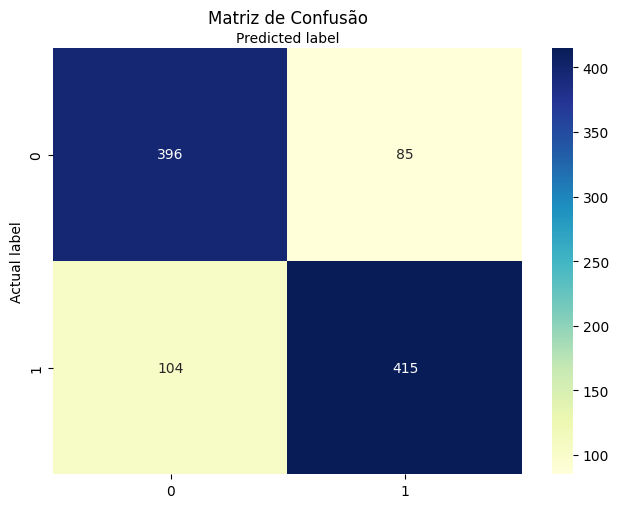

In [ ]:
# Basta pegar TP, Tn, FP, FN e colocar como martriz

cnf_matrix = [[TP, FP], 
             [FN, TN]] 


import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Matriz de Confusão', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')






### 6) Analise dos tweets (PARTE FINAL)

In [ ]:
tweets = spark.sparkContext.wholeTextFiles(
    '/content/drive/MyDrive/MESTRADO/2-PERIODO/Analise_nao_estruturada_de_dados/ProjetoFinal(OFICIAL)/PROJETO_FINAL/EXTRACAO_E_PRE-PROCESSAMENTO_DADOS/DADOS_TWEETS/usar/')



tweets = spark.createDataFrame(tweets , ['path', 'text'])
tweets = tweets.repartition(100)
tweets = tweets.withColumn('label', lit(1)).persist()

tweets = nlp_pipeline.transform(tweets) \
    .selectExpr(
        'path', 'text', 'label', 
        'normalized.result AS normalized', 
        'embeddings.embeddings'
    )


tweets = tweets.withColumn('avg_wordvec', avg_wordvecs('embeddings'))
tweets = tweets.drop('embeddings')
tweets = tweets.persist()

preds_tweets = model.transform(tweets)


### 6.1) Calculando a quantidade de positivo e negativo.

In [ ]:
import pandas as pd
import sys


a = preds_tweets.select(['prediction'])

a.show()

positivo = 67.3


negativo = 32.7


+----------+
|prediction|
+----------+
|       1.0|
|       1.0|
|       1.0|
|       1.0|
|       0.0|
|       0.0|
|       1.0|
|       0.0|
|       0.0|
|       1.0|
|       0.0|
|       0.0|
|       1.0|
|       0.0|
|       1.0|
|       1.0|
|       1.0|
|       0.0|
|       1.0|
|       1.0|
+----------+
only showing top 20 rows



### 6.2) Pie

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


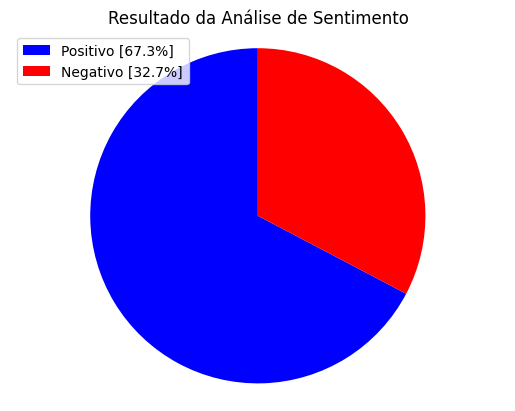

In [ ]:
!pip install textblob

from textblob import TextBlob
import matplotlib.pyplot as plt




labels = ['Positivo ['+str(positivo)+'%]' ,'Negativo ['+str(negativo)+'%]']
sizes = [positivo, negativo]
colors = ['blue','red']
patches, texts = plt.pie(sizes,colors=colors, startangle=90)
plt.style.use('default')
plt.legend(labels)
plt.title("Resultado da Análise de Sentimento")
plt.axis('equal')
plt.show()

### O script a seguir é opcional

In [ ]:
%%writefile movie_review_analysis.py

"""
This script takes file containing reviews of the same. 
It will output the results of the analysis to std.out.
"""


import argparse as ap
import json
from pyspark.sql import SparkSession
from pyspark.ml import PipelineModel


if __name__ == '__main__':
    print('beginning...')
    parser = ap.ArgumentParser(description='Movie Review Analysis')
    parser.add_argument('-file', metavar='DATA', type=str,
                        required=True, 
                        help='The file containing the reviews '\
                             'in JSON format, one JSON review '\
                             'per line')
    
    options = vars(parser.parse_args())
    
    spark = SparkSession.builder \
        .master("local[*]") \
        .appName("Movie Analysis") \
        .config("spark.driver.memory", "12g") \
        .config("spark.executor.memory", "12g") \
        .config("spark.jars.packages", 
                "JohnSnowLabs:spark-nlp:2.2.2") \
        .getOrCreate()
    
    nlp_pipeline = PipelineModel.load('nlp_pipeline.3.12')
    model = PipelineModel.load('model.3.12')
    
    data = spark.read.json(options['file'])
    
    nlp_procd = nlp_pipeline.transform(data)
    preds = model.transform(nlp_procd)
    
    results = preds.selectExpr(
        'count(*)',
        'mean(rawPrediction[1])',
        'std(rawPrediction[1])',
        'median(rawPrediction[1])',
        'min(rawPrediction[1])',
        'max(rawPrediction[1])',
    ).first().asDict()
    
    print(json.dump(results))

Writing movie_review_analysis.py
